<a href="https://colab.research.google.com/github/erickamabilin/PDS_MAEPS/blob/main/CPT_MAEPS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>





   
# Download, read and load the raw data



In [2]:
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import io
import psycopg2
import re

In [3]:
!pip install gdown -q
!gdown --id 13NHW7x3PfT4URc8x0XSK9oZdNoebdrxS --output vw_cpt_brussels_params_completeset_20250318_remapped.parquet
raw = pd.read_parquet('vw_cpt_brussels_params_completeset_20250318_remapped.parquet')

/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=13NHW7x3PfT4URc8x0XSK9oZdNoebdrxS
To: /content/vw_cpt_brussels_params_completeset_20250318_remapped.parquet
100% 64.6M/64.6M [00:01<00:00, 59.8MB/s]


In [4]:
raw = raw.drop(['index','sondeernummer','pkey_sondering'], axis=1)

In [ ]:
raw.to_csv("cpt.csv", index=False)

# Database


In [5]:
# !pip -q install psycopg2-binary pandas python-dotenv

# ---------- 1) Connection (Supabase pooled port 6543 + SSL) ----------
user     = "postgres.vsqvzufrqjpjyulhetwl"
password = "MAEPSmaeps12345"
host     = "aws-1-eu-central-1.pooler.supabase.com"
port     = 6543
dbname   = "postgres"

def get_conn():
    return psycopg2.connect(
        host=host, port=port, dbname=dbname, user=user, password=password,
        sslmode="require"
    )

TABLE_STAGING = "stg_cpt_raw"

# ---------- 2) Sanitize columns (you already did this) ----------
def sanitize(name: str) -> str:
    s = re.sub(r'\s+', '_', str(name).strip())
    s = re.sub(r'[^0-9a-zA-Z_]', '_', s)
    if s and s[0].isdigit():
        s = '_' + s
    return s.lower()

raw = raw.copy()
orig2san, seen, new_cols = {}, set(), []
for c in raw.columns:
    base = sanitize(c)
    name = base
    i = 1
    while name in seen:
        name = f"{base}_{i}"; i += 1
    seen.add(name)
    orig2san[c] = name
    new_cols.append(name)
raw.columns = new_cols
print("Columns ->", raw.columns.tolist())

# ---------- 3) Create staging table ----------
ddl_cols = ",\n  ".join([f'"{c}" TEXT' for c in raw.columns])
ddl = f'CREATE TABLE IF NOT EXISTS {TABLE_STAGING} (\n  {ddl_cols}\n);'

with get_conn() as conn:
    conn.autocommit = True
    with conn.cursor() as cur:
        cur.execute(ddl)
print("Staging table ready.")


# ---------- 4) Bulk load DataFrame via COPY FROM STDIN ----------
cols_quoted = ", ".join([f'"{c}"' for c in raw.columns])
copy_sql = f"""
COPY {TABLE_STAGING} ({cols_quoted})
FROM STDIN WITH (FORMAT csv, HEADER true, DELIMITER ',', QUOTE '\"', NULL '');
"""

def copy_df(df_chunk: pd.DataFrame):
    buf = io.StringIO()
    df_chunk.to_csv(buf, index=False)  # header included
    buf.seek(0)
    with get_conn() as conn:
        with conn.cursor() as cur:
            cur.copy_expert(copy_sql, buf)
        conn.commit()

copy_df(raw)
print("Loaded DataFrame into staging table.")

# ---------- 5) Verify row count ----------
with get_conn() as conn:
    with conn.cursor() as cur:
        cur.execute(f"SELECT COUNT(*) FROM {TABLE_STAGING};")
        print("Rows in staging:", cur.fetchone()[0])

TYPED_TABLE = "cpt_brussels_params"
typed_sql = f"""
DROP TABLE IF EXISTS {TYPED_TABLE};
CREATE TABLE {TYPED_TABLE} AS
SELECT
  COALESCE(NULLIF(sondeernummer, ''), NULL)::text               AS sondeernummer,
  NULLIF(x, '')::double precision                               AS x,
  NULLIF(y, '')::double precision                               AS y,
  NULLIF(diepte_mtaw, '')::double precision                     AS diepte_mtaw,
  NULLIF(qc, '')::double precision                               AS qc,
  NULLIF(fs, '')::double precision                               AS fs,
  NULLIF(rf, '')::double precision                               AS rf
  -- TODO: add the rest of your columns with appropriate casts
FROM {TABLE_STAGING};

CREATE INDEX IF NOT EXISTS idx_{TYPED_TABLE}_sondeer ON {TYPED_TABLE}(sondeernummer);
CREATE INDEX IF NOT EXISTS idx_{TYPED_TABLE}_xy ON {TYPED_TABLE}(x, y);
"""


Columns -> ['sondering_id', 'x', 'y', 'start_sondering_mtaw', 'diepte_sondering_tot', 'diepte', 'diepte_mtaw', 'qc', 'fs', 'qtn', 'rf', 'fr', 'icn', 'sbt', 'ksbt', 'lithostrat_id']
Staging table ready.
Loaded DataFrame into staging table.
Rows in staging: 2445422


# Separate labeled and unlabeled data


In [63]:
user     = "postgres.vsqvzufrqjpjyulhetwl"
password = "MAEPSmaeps12345"
host     = "aws-1-eu-central-1.pooler.supabase.com"
port     = 6543
dbname   = "postgres"

def get_conn():
    return psycopg2.connect(
        host=host, port=port, dbname=dbname, user=user, password=password,
        sslmode="require"
    )

query = "SELECT * FROM raw.labelled_cpt"

with get_conn() as conn:
    labeled_data = pd.read_sql(query, conn)

print("Data loaded from raw.labelled_cpt")
display(labeled_data.head())

/tmp/ipython-input-3431142227.py:16: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  labeled_data = pd.read_sql(query, conn)


Data loaded from raw.labelled_cpt


,sondering_id,x,y,start_sondering_mtaw,diepte_sondering_tot,diepte,diepte_mtaw,qc,fs,qtn,rf,fr,icn,sbt,ksbt,lithostrat_id
0,314,153278.2,181734.6,15.26,25.4,1.6,13.66,1.17,0.035,35.89400438353187,2.991452991452992,3.0583711988815097,2.56434,5.0,1.434e-07,Quartair
1,314,153278.2,181734.6,15.26,25.4,1.7,13.56,1.57,0.033,42.56231931660572,2.1019108280254777,2.1389681099299973,2.406724,5.0,4.321e-07,Quartair
2,314,153278.2,181734.6,15.26,25.4,1.8,13.459999999999999,1.43,0.036,38.53699112706456,2.5174825174825175,2.5692263773908075,2.491219,5.0,2.392e-07,Quartair
3,314,153278.2,181734.6,15.26,25.4,1.9,13.36,0.5,0.024,15.678500768214604,4.8,5.111165775078922,2.982185,3.0,7.7e-09,Quartair
4,314,153278.2,181734.6,15.26,25.4,2.0,13.26,1.33,0.023,33.203118561084175,1.7293233082706767,1.7721100750416183,2.440158,5.0,3.419e-07,Quartair


In [64]:
numeric_cols = ['x',
 'y',
 'start_sondering_mtaw',
 'diepte_sondering_tot',
 'diepte',
 'diepte_mtaw',
 'qc',
 'fs',
 'qtn',
 'rf',
 'fr',
 'icn',
 'sbt',
 'ksbt']
labeled_data[numeric_cols] = labeled_data[numeric_cols].apply(pd.to_numeric)

In [67]:
# Run only if we want to separate layers with two labels with + separator
# Split two layers in one label
labeled_data['lithostrat_id'] = labeled_data['lithostrat_id'].str.split(r'\s*\+\s*')

# Expand each list into multiple rows
labeled_data = labeled_data.explode('lithostrat_id', ignore_index=True)

In [69]:
# Check Missingness
labeled_data.describe(include='all')

,sondering_id,x,y,start_sondering_mtaw,diepte_sondering_tot,diepte,diepte_mtaw,qc,fs,qtn,rf,fr,icn,sbt,ksbt,lithostrat_id
count,229712,229712.000000,229712.000000,229712.000000,229712.000000,229712.000000,229712.000000,229712.000000,229712.000000,229712.000000,229712.000000,229712.000000,229663.000000,229663.000000,2.296630e+05,218822
unique,242,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27
top,13081,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Quartair
freq,4502,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50114
mean,NaN,150841.633443,174295.718352,60.032023,21.481577,11.115052,48.916971,7.837977,0.171518,89.747659,2.573272,2.750621,2.341620,4.884566,3.624308e-05,NaN
std,NaN,6462.260159,4260.393361,27.086452,7.121785,7.284599,28.162086,7.849809,0.176871,103.895085,3.316960,8.127418,0.424227,0.887044,1.106157e-03,NaN
min,NaN,139799.200000,164730.190000,14.330000,3.660000,0.020000,-13.830000,0.001000,0.000054,0.001000,0.002309,0.001000,0.431061,2.000000,0.000000e+00,NaN
25%,NaN,143925.218000,171171.349000,43.090000,16.560000,5.280000,30.350000,2.462950,0.058000,26.007253,1.451613,1.499422,2.037102,4.000000,6.120000e-08,NaN
50%,NaN,150703.297000,174557.000000,57.180000,20.370000,9.840000,46.160000,5.080000,0.104000,62.793000,2.344686,2.475068,2.311483,5.000000,8.416000e-07,NaN
75%,NaN,157234.890000,177932.350000,72.590000,26.180000,15.780000,64.520000,11.280000,0.232000,114.824230,3.335396,3.566580,2.685982,6.000000,5.743950e-06,NaN


{'whiskers': [<matplotlib.lines.Line2D at 0x7fb0bbbe4200>,
 'caps': [<matplotlib.lines.Line2D at 0x7fb0bbbe50d0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fb0bbbe77d0>],
 'medians': [<matplotlib.lines.Line2D at 0x7fb0bbbe4740>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fb0bbbe4590>],
 'means': []}

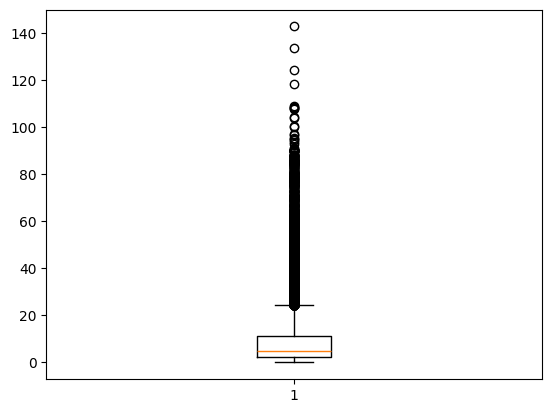

In [70]:
# Check Range
plt.boxplot(labeled_data['qc'])

{'whiskers': [<matplotlib.lines.Line2D at 0x7fb0dc651460>,
 'caps': [<matplotlib.lines.Line2D at 0x7fb0dc651a90>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fb0cd2037d0>],
 'medians': [<matplotlib.lines.Line2D at 0x7fb0dc652030>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fb0dc6522d0>],
 'means': []}

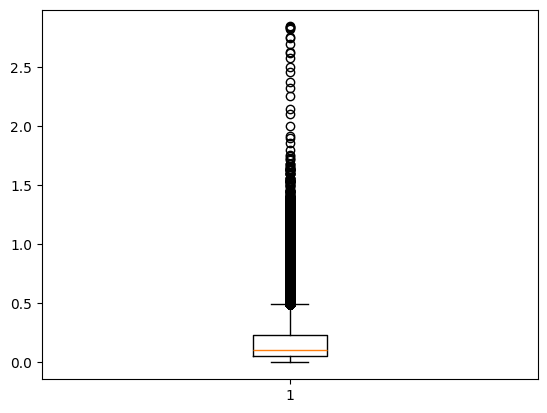

In [71]:
plt.boxplot(labeled_data['fs'])

In [72]:
# Add an ID column for lithostrat_id, only what we gathered from meeting (will add if file is uploaded)
layer_id = {'Aalbeke' : 1670,
'Asse' : 1410,
'Bolderberg' : 1121,
'Brussel' : 1480,
'Diest' : 1120,
'Kwatrecht' : 1540,
'Lede' : 1440,
'Merelbeke' : 1530,
'Mons_en_Pevele' : 1690,
'Mont_Panisel' : 1570,
'Orchies' : 1700,
'Quartair' : 1059,
'Sint_Huibrechts_Hern' : 1350,
'Ursel' : 1400,
'Wemmel' : 1420}

In [73]:
# No ID number layers as -1
labeled_data['lithostrat_num'] = labeled_data['lithostrat_id'].map(layer_id).fillna(-1).astype(int)

In [74]:
impt_layers_only = labeled_data[labeled_data['lithostrat_num'] != -1]

In [75]:
dummies = pd.get_dummies(impt_layers_only['lithostrat_id'])
impt_layers_only = pd.concat([impt_layers_only, dummies], axis=1)

In [106]:
impt_layers_only[['qc','fs', 'rf', 'diepte']].corr()

,qc,fs,rf,diepte
qc,1.000000,0.717849,-0.127249,0.210896
fs,0.717849,1.000000,0.119881,0.351020
rf,-0.127249,0.119881,1.000000,0.059365
diepte,0.210896,0.351020,0.059365,1.000000


In [105]:
impt_layers_only[['qc','fs', 'rf', 'diepte']].skew()

,0
qc,2.511213
fs,2.051881
rf,144.554810
diepte,0.694578


In [80]:
impt_layers_only['log_qc'] = np.log(impt_layers_only['qc'])
impt_layers_only['log_fs'] = np.log(impt_layers_only['fs'])

# Train, Test, Validation Datasets

In [82]:
#excluded_ids = {4629, 3892, 3675, 4455, 4859, 14000, 4449} # Rare layers
#sondering_id = [i for i in labeled_data["sondering_id"].unique() if i not in excluded_ids]
sondering_id = labeled_data["sondering_id"].unique()
train_sondering_id = [i for i in sondering_id[:int(len(sondering_id)*0.9)]]
test_sondering_id = [i for i in sondering_id if i not in train_sondering_id]
impt_layers_only.groupby("lithostrat_id").agg(distinct_sondering_id=('sondering_id', 'nunique'), total_records=('sondering_id', 'count'),id=('sondering_id','max')).sort_values(by='distinct_sondering_id')

,distinct_sondering_id,total_records,id
lithostrat_id,,,
Orchies,1,250,4449
Diest,6,8711,4415
Bolderberg,7,2181,4678
Merelbeke,10,1144,4383
Sint_Huibrechts_Hern,11,7985,4919
Ursel,21,3964,4678
Kwatrecht,24,4337,4647
Asse,29,4906,4916
Aalbeke,41,11465,495


In [83]:
X = impt_layers_only.drop('lithostrat_id', axis=1)
y = impt_layers_only['lithostrat_id']
x_train = X[X['sondering_id'].isin(train_sondering_id)]
x_test = X[X['sondering_id'].isin(test_sondering_id)]
y_train = y[X['sondering_id'].isin(train_sondering_id)]
y_test = y[X['sondering_id'].isin(test_sondering_id)]

print("Train-test split based on sondering_id complete.")
print(f"Training set shape: {x_train.shape}")
print(f"Test set shape: {x_test.shape}")

Train-test split based on sondering_id complete.
Training set shape: (148411, 33)
Test set shape: (45724, 33)


## Handling categorical data

In [ ]:
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

numerical_features = x_train.select_dtypes(include=['number']).columns.tolist()
numerical_features.remove('sondering_id')
categorical_features = x_train.select_dtypes(include=['object']).columns.tolist()
numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)])


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline

pipeline_lr = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', LogisticRegression(max_iter=1000))])

pipeline_rf = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', RandomForestClassifier(random_state=0))])

pipeline_xgb = Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=0))])

pipeline_gb = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', GradientBoostingClassifier(random_state=0))])

print("Logistic Regression Pipeline:")
display(pipeline_lr)

print("\nRandom Forest Pipeline:")
display(pipeline_rf)

print("\nXGBoost Pipeline:")
display(pipeline_xgb)

print("\nGradient Boosting Pipeline:")
display(pipeline_gb)

Logistic Regression Pipeline:


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['x', 'y',
                                                   'start_sondering_mtaw',
                                                   'diepte_sondering_tot',
                                                   'diepte', 'diepte_mtaw',
                                                   'qc', 'fs', 'qtn', 'rf',
                                                   'fr', 'icn', 'sbt',
                                                   'ksbt']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  [])])),
                ('classifier', LogisticRegression(max_iter=1000))])


Random Forest Pipeline:


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['x', 'y',
                                                   'start_sondering_mtaw',
                                                   'diepte_sondering_tot',
                                                   'diepte', 'diepte_mtaw',
                                                   'qc', 'fs', 'qtn', 'rf',
                                                   'fr', 'icn', 'sbt',
                                                   'ksbt']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  [])])),
                ('classifier', RandomForestClassifier(random_state=0))])


XGBoost Pipeline:


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['x', 'y',
                                                   'start_sondering_mtaw',
                                                   'diepte_sondering_tot',
                                                   'diepte', 'diepte_mtaw',
                                                   'qc', 'fs', 'qtn', 'rf',
                                                   'fr', 'icn', 'sbt',
                                                   'ksbt']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  [])])),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_by...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, ...))])


Gradient Boosting Pipeline:


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['x', 'y',
                                                   'start_sondering_mtaw',
                                                   'diepte_sondering_tot',
                                                   'diepte', 'diepte_mtaw',
                                                   'qc', 'fs', 'qtn', 'rf',
                                                   'fr', 'icn', 'sbt',
                                                   'ksbt']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  [])])),
                ('classifier', GradientBoostingClassifier(random_state=0))])

In [ ]:
from sklearn.preprocessing import LabelEncoder

print("Training Logistic Regression...")
pipeline_lr.fit(x_train, y_train)
print("Logistic Regression training complete.")

print("\nTraining Random Forest...")
pipeline_rf.fit(x_train, y_train)
print("Random Forest training complete.")

print("\nTraining XGBoost...")
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
pipeline_xgb.fit(x_train, y_train_encoded)
print("XGBoost training complete.")

# print("\nTraining Gradient Boosting...")
# pipeline_gb.fit(x_train, y_train)
# print("Gradient Boosting training complete.")

Training Logistic Regression...
Logistic Regression training complete.

Training Random Forest...
Random Forest training complete.

Training XGBoost...


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [13:12:46] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost training complete.


In [ ]:
from sklearn.utils import shuffle

# Shuffle the test set while keeping features and target aligned
x_test_shuffled, y_test_shuffled = shuffle(x_test, y_test, random_state=0)

print("Test set has been shuffled.")

Test set has been shuffled.


In [ ]:
# Evaluate each model on the test set
score_lr = pipeline_lr.score(x_test_shuffled, y_test_shuffled)

score_rf = pipeline_rf.score(x_test_shuffled, y_test_shuffled)

y_test_encoded = label_encoder.transform(y_test_shuffled)
score_xgb = pipeline_xgb.score(x_test_shuffled, y_test_encoded)

# score_gb = pipeline_gb.score(x_test_shuffled, y_test_shuffled)

print(f'Logistic Regression Test Set Accuracy: {score_lr:.2f}')
print(f'Random Forest Test Set Accuracy: {score_rf:.2f}')
print(f'XGBoost Test Set Accuracy: {score_xgb:.2f}')
# print(f'Gradient Boosting Test Set Accuracy: {score_gb:.2f}')

Logistic Regression Test Set Accuracy: 0.40
Random Forest Test Set Accuracy: 0.22
XGBoost Test Set Accuracy: 0.19


In [ ]:
import pickle

filename_lr = 'logistic_regression_pipeline.pkl'
filename_rf = 'random_forest_pipeline.pkl'
filename_xgb = 'xgboost_pipeline.pkl'
filename_gb = 'gradient_boosting_pipeline.pkl'

with open(filename_lr, 'wb') as f:
    pickle.dump(pipeline_lr, f)
print(f"Logistic Regression pipeline saved to {filename_lr}")

with open(filename_rf, 'wb') as f:
    pickle.dump(pipeline_rf, f)
print(f"Random Forest pipeline saved to {filename_rf}")

with open(filename_xgb, 'wb') as f:
    pickle.dump(pipeline_xgb, f)
print(f"XGBoost pipeline saved to {filename_xgb}")

with open(filename_gb, 'wb') as f:
    pickle.dump(pipeline_gb, f)
print(f"Gradient Boosting pipeline saved to {filename_gb}")

Logistic Regression pipeline saved to logistic_regression_pipeline.pkl
Random Forest pipeline saved to random_forest_pipeline.pkl
XGBoost pipeline saved to xgboost_pipeline.pkl
Gradient Boosting pipeline saved to gradient_boosting_pipeline.pkl


## Heirarchical Logistic / Random Forest - Trial

In [156]:
# Try heirarchical Logistic Regresion / Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

In [140]:
impt_layers_lr = impt_layers_only.copy()

In [141]:
features = ['log_qc', 'log_fs', 'rf', 'diepte']
layer_order = ['Quartair',
'Diest',
'Bolderberg',
'Sint_Huibrechts_Hern',
'Ursel',
'Asse',
'Wemmel',
'Lede',
'Brussel',
'Merelbeke',
'Kwatrecht',
'Mont_Panisel',
'Aalbeke',
'Mons_en_Pevele',
'Orchies']

In [142]:
# Train a classifier for each layer boundary
models_lr = {}
for layer in layer_order:
    y = impt_layers_lr[f'{layer}']
    clf_lr = LogisticRegression(solver='liblinear')
    clf_lr.fit(impt_layers_lr[features], y)
    models_lr[layer] = clf_lr

probs_lr = pd.DataFrame(index=impt_layers_lr.index)

for layer in layer_order:
    probs_lr[layer] = models_lr[layer].predict_proba(impt_layers_lr[features])[:, 1]

probs_lr

,Quartair,Diest,Bolderberg,Sint_Huibrechts_Hern,Ursel,Asse,Wemmel,Lede,Brussel,Merelbeke,Kwatrecht,Mont_Panisel,Aalbeke,Mons_en_Pevele,Orchies
0,0.848129,0.005562,0.060310,0.050075,0.082415,0.083419,0.015450,0.011001,0.009764,0.006295,0.034382,0.084567,0.038629,0.007645,0.000099
1,0.859815,0.005257,0.046171,0.036497,0.022938,0.040844,0.007633,0.019449,0.030245,0.001593,0.024762,0.066816,0.006907,0.008125,0.000135
2,0.841530,0.006225,0.051467,0.044302,0.043929,0.060649,0.011619,0.016304,0.018592,0.003153,0.029897,0.074930,0.016513,0.008427,0.000113
3,0.870982,0.001062,0.075162,0.047507,0.287551,0.110774,0.021852,0.001494,0.000750,0.042947,0.030188,0.131247,0.298462,0.004554,0.000074
4,0.891930,0.002093,0.039783,0.023779,0.012021,0.026617,0.003512,0.016280,0.036688,0.000949,0.025406,0.072449,0.004057,0.006483,0.000281
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
229707,0.000026,0.005891,0.000083,0.019509,0.002477,0.013700,0.130154,0.211843,0.014701,0.016938,0.018137,0.499956,0.365551,0.663299,0.000431
229708,0.000024,0.005055,0.000083,0.020225,0.002837,0.012106,0.151860,0.157788,0.009324,0.021082,0.012857,0.492504,0.396638,0.656825,0.000279
229709,0.000023,0.005263,0.000082,0.020894,0.002846,0.011335,0.164519,0.149748,0.008487,0.021546,0.010917,0.482308,0.386751,0.662683,0.000225
229710,0.000023,0.006139,0.000081,0.020607,0.002577,0.012463,0.150446,0.190382,0.012021,0.018341,0.013957,0.486430,0.363074,0.671682,0.000301


In [143]:
def hierarchical_predict(row_idx, layer_order, probs_df):
    for layer in layer_order:
        if probs_df.iloc[row_idx][layer] > 0.5:
            return layer
    return probs_df.iloc[row_idx].idxmax()

impt_layers_lr['predicted_layer'] = [
    hierarchical_predict(i, layer_order, probs_lr)
    for i in range(len(impt_layers_lr))
]

In [144]:
impt_layers_lr['check'] = (impt_layers_lr['predicted_layer'] == impt_layers_lr['lithostrat_id']).astype(int)
validation_lr = impt_layers_lr.groupby('lithostrat_id')['check'].agg(['sum', 'count'])
validation_lr['accuracy'] = validation_lr['sum'] / validation_lr['count']
validation_lr

,sum,count,accuracy
lithostrat_id,,,
Aalbeke,3216,11465,0.280506
Asse,0,4906,0.000000
Bolderberg,0,2181,0.000000
Brussel,11668,24880,0.468971
Diest,2614,8711,0.300080
Kwatrecht,0,4337,0.000000
Lede,10358,22433,0.461730
Merelbeke,0,1144,0.000000
Mons_en_Pevele,2541,18097,0.140410


In [145]:
impt_layers_rf = impt_layers_only.copy()

In [146]:
models_rf = {}
for layer in layer_order:
    y = impt_layers_rf[f'{layer}']
    clf_rf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf_rf.fit(impt_layers_rf[features], y)
    models_rf[layer] = clf_rf

In [147]:
probs_rf = pd.DataFrame(impt_layers_rf.index)

for layer in layer_order:
    probs_rf[layer] = models_rf[layer].predict_proba(impt_layers_rf[features])[:, 1]

probs_rf

,0,Quartair,Diest,Bolderberg,Sint_Huibrechts_Hern,Ursel,Asse,Wemmel,Lede,Brussel,Merelbeke,Kwatrecht,Mont_Panisel,Aalbeke,Mons_en_Pevele,Orchies
0,0,0.990000,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0
1,1,0.990000,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0
2,2,1.000000,0.0,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0
3,3,0.960000,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0
4,4,0.966667,0.0,0.03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194130,229707,0.000000,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.98,0.0,0.05,0.0
194131,229708,0.000000,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.98,0.0,0.10,0.0
194132,229709,0.000000,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.00,0.0,0.13,0.0
194133,229710,0.000000,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.99,0.0,0.09,0.0


In [148]:
impt_layers_rf['predicted_layer'] = [
    hierarchical_predict(i, layer_order, probs_rf)
    for i in range(len(impt_layers_rf))
]

In [149]:
impt_layers_rf['check'] = (impt_layers_rf['predicted_layer'] == impt_layers_rf['lithostrat_id']).astype(int)
validation_rf = impt_layers_rf.groupby('lithostrat_id')['check'].agg(['sum', 'count'])
validation_rf['accuracy'] = validation_rf['sum'] / validation_rf['count']
validation_rf

,sum,count,accuracy
lithostrat_id,,,
Aalbeke,10964,11465,0.956302
Asse,4903,4906,0.999389
Bolderberg,2178,2181,0.998624
Brussel,24875,24880,0.999799
Diest,8711,8711,1.000000
Kwatrecht,4319,4337,0.995850
Lede,22431,22433,0.999911
Merelbeke,1127,1144,0.985140
Mons_en_Pevele,18095,18097,0.999889


In [159]:
# Try RF in the test dataset
X_test = x_test[features]
X_test

,log_qc,log_fs,rf,diepte
179905,0.259440,-3.170201,3.239858,9.01
179906,0.239939,-3.231551,3.107070,9.02
179907,0.220052,-3.252938,3.102413,9.03
179908,0.206570,-3.260231,3.121674,9.04
179909,0.186000,-3.289609,3.094299,9.05
...,...,...,...,...
229707,2.708717,-0.371064,4.596935,35.42
229708,2.660260,-0.329894,5.027972,35.44
229709,2.689207,-0.275754,5.156250,35.46
229710,2.741485,-0.286350,4.842037,35.48


In [160]:
probs_test = pd.DataFrame(index=X_test.index)

for layer, model in models_rf.items():
    probs_test[layer] = model.predict_proba(X_test)[:, 1]

X_test['predicted_layer'] = [
    hierarchical_predict(i, layer_order, probs_test)
    for i in range(len(X_test))
]

y_pred = X_test['predicted_layer']
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

/tmp/ipython-input-4241743055.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['predicted_layer'] = [


Accuracy: 0.9453897296824425
                precision    recall  f1-score   support

       Aalbeke       0.96      0.96      0.96      8512
     Kwatrecht       1.00      1.00      1.00      1540
          Lede       1.00      1.00      1.00      2901
     Merelbeke       1.00      1.00      1.00       835
Mons_en_Pevele       1.00      1.00      1.00     10679
  Mont_Panisel       0.94      0.91      0.92     13924
      Quartair       0.84      0.88      0.86      7333

      accuracy                           0.95     45724
     macro avg       0.96      0.96      0.96     45724
  weighted avg       0.95      0.95      0.95     45724

